In this notebook, we inspect **in which way a tabular dataset as Census can be used by an AI based on graphs to estimate wealthiness of individuals**. 

Therefore, we proceed in 2 steps:

**1. We prepare data to be handled by a model based on a graph**
We transform them into a graph, that involves strong assumptions on the features involved in connections...

**2. We train an AI based on graphs**
Here, we begin with a Graphical Neural Network (GNN) based on a Multi-Layer Perceptron (MLP), requiring the library Torch.

**3. We inspect if the graph-based AI indeed reflects common & expert knowledge on**
In particular, regarding the non-sense of certain inferences that should absolutely be avoided (e.g. education may influence occupation, but not the reverse).

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# Data preparation for binary classification with graphs (Census)
For this reshaping (and also interpretation, see below the choice of edges) of data tables to graphs, we based on https://colab.research.google.com/drive/1_eR7DXBF3V4EwH946dDPOxeclDBeKNMD?usp=sharing#scrollTo=WuggdIItffpv.

## General preparation - handle categorical features
Here, we handle the categorical features through label-encoding. 

In [2]:
import sys
sys.path.append("../")

import time
from sklearn import datasets

from sklearn.preprocessing import LabelEncoder

from torch_geometric.data import Data

import tensorflow as tf

import itertools
import numpy as np
import pandas as pd

from classif_basic.data_preparation import train_valid_test_split, set_target_if_feature, automatic_preprocessing

2023-02-04 05:14:39.027423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 05:14:41.172589: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-04 05:14:41.172666: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-04 05:14:41.172677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

### Prepare data

Fix precise % of population distribution (sex: Male, Female) and % of wealthiness according to sex. In that way, we could inspect if the structure of the model (here based on a graph) integrates this "sexist" representation of the world. 

In [3]:
# preparing the dataset on clients for binary classification
from sklearn.datasets import fetch_openml
data = fetch_openml(data_id=1590, as_frame=True)

t0 = time.time()

X = data.data
Y = (data.target == '>50K') * 1

In [4]:
dataset = X.copy()
dataset['target'] = Y
dataset

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,0
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,0
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,1
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,1
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States,0
48838,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,1
48839,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States,0
48840,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States,0


In [5]:
# here, "treatment" is saw as being 'Male' and not 'Female'

df_response_if_feature=dataset.loc[(dataset['sex']=='Male')&(dataset['target']==1)]
df_no_response_if_feature=dataset.loc[(dataset['sex']=='Male')&(dataset['target']==0)]
df_response_if_not_feature=dataset.loc[(dataset['sex']=='Female')&(dataset['target']==1)]
df_no_response_if_not_feature=dataset.loc[(dataset['sex']=='Female')&(dataset['target']==0)]

print(df_response_if_feature.shape[0])
print(df_no_response_if_feature.shape[0])
print(df_response_if_not_feature.shape[0])
print(df_no_response_if_not_feature.shape[0])


# % of men selected by the initial data
df_response_if_feature.shape[0]/(df_response_if_feature.shape[0]+df_no_response_if_feature.shape[0])

9918
22732
1769
14423


0.3037672281776417

In [6]:
# % of women selected by the initial data
df_response_if_not_feature.shape[0]/(df_response_if_feature.shape[0]+df_no_response_if_not_feature.shape[0])

0.07267573230352081

In [7]:
len_dataset = 20_000

percentage_feature= 70
percentage_response_if_feature=70
percentage_response_if_not_feature=10

sexist_dataset = set_target_if_feature(
    df_response_if_feature=df_response_if_feature,
    df_no_response_if_feature=df_no_response_if_feature,
    df_response_if_not_feature=df_response_if_not_feature,
    df_no_response_if_not_feature=df_no_response_if_not_feature,
    len_dataset=len_dataset,
    percentage_feature=percentage_feature,
    percentage_response_if_feature=percentage_response_if_feature,
    percentage_response_if_not_feature=percentage_response_if_not_feature)

len_dataset: 20000
nb indivs feature with response: 9800
nb indivs feature with no response: 4200
nb indivs not_feature with response: 600
nb indivs not_feature with no response: 5400


In [8]:
X = sexist_dataset.loc[: , dataset.columns != 'target']
Y = sexist_dataset['target']

In [9]:
Y

39662    1
40510    1
8596     1
21034    1
46154    1
        ..
5804     0
11156    0
4897     0
13221    0
46462    0
Name: target, Length: 20000, dtype: int64

### Train-test-split, to prepare for 3 graphs representing data

In [10]:
model_task = "classification"
preprocessing_cat_features = "label_encoding"

X_train, X_valid, X_train_valid, X_test, Y_train, Y_valid, Y_train_valid, Y_test = train_valid_test_split(
    X=X,
    Y=Y, 
    model_task=model_task,
    preprocessing_cat_features=preprocessing_cat_features)

## Reshape (by interpreting) data to a graph

From this dataset (where we introduced selectively a "sexist" effect against women), let's see how we could swith from the tabular data to a graph representation.

The point is that our features X all seem to be attributes of the clients, though we should find a way of representing their interactions between clients 

X = {race, age, sex, final weight (depends on age, sex, hispanic origin, race), education, education number, marital status, relationship, occupation, hours per week, workclass, race, sex, capital gain, capital loss, native country} 

**Nodes** 
Bank clients (by ID)

**Edges** 
Here, we should find one or several ways of connecting the clients

Should be occupation → if changes of occupation (or similar client with new occupation), which impact on the revenue? // change of football team => impact on the football rate 
(pers) actionable => predict revenue when switches to a new job??
→ may be: “hours per week” <=> inspect the change of revenue if switches to greater hours per week?

**Node Features** 
Attributs of the nodes, i.e. characteristics of the clients (here, hard to separate from what "connects" them...) 

Race, age, sex, final weight (depends on age, sex, hispanic origin, race), education, education number, marital status, relationship, hours per week, workclass, race, sex, capital gain, capital loss, native country 

**Label (here at a node-level?)** 
Income (Y = income > $50 000)

In [11]:
# first of all, specify the edge
edge = "occupation"# str (for the moment)

In [12]:
# get an idea of the codes corresponding to occupations, reconstituting labels' transformations from X
le = LabelEncoder()

dict_occupation_codes = pd.Series(X[edge].values, index=X.apply(le.fit_transform)[edge]).to_dict()

# correct according to dict comparison
dict_occupation_codes[14] = 'Transport-moving'
dict_occupation_codes

{3: 'Exec-managerial',
 9: 'Prof-specialty',
 2: 'Craft-repair',
 11: 'Sales',
 0: 'Adm-clerical',
 6: 'Machine-op-inspct',
 10: 'Protective-serv',
 14: 'Transport-moving',
 12: 'Tech-support',
 13: 'Transport-moving',
 4: 'Farming-fishing',
 5: 'Handlers-cleaners',
 7: 'Other-service',
 1: 'Armed-Forces',
 8: 'Priv-house-serv'}

In [13]:
# With the profession types, this tells us how many clients per type of profession we have to connect
df_jobs = X.replace({"occupation": dict_occupation_codes})
df_jobs["occupation"].value_counts()

Exec-managerial      3426
Prof-specialty       3323
Sales                2494
Craft-repair         2261
Adm-clerical         2113
Other-service        1466
Machine-op-inspct     988
Transport-moving      865
Tech-support          646
Handlers-cleaners     538
Protective-serv       441
Farming-fishing       438
Priv-house-serv        78
Armed-Forces            6
Name: occupation, dtype: int64

In [14]:
# TODO enhance the function (and then include it in the package)

def table_to_graph(X, Y, edge):
    
    #Make sure that we have no duplicate nodes
    assert(X.index.unique().shape[0] == X.shape[0])
    
    # Extract the node features

        # The node features are typically represented in a matrix of the shape (num_nodes, node_feature_dim).
        # For each of the bank clients, we simply extract their attributes (except here the "occupation", that would be used as an "actionable" edge to connect them)
    node_features = X.loc[:, X.columns != edge]
        # That's already our node feature matrix. The number of nodes and the ordering is implicitly defined by it's shape. Each row corresponds to one node in our final graph. 
    
    # Convert to numpy
    x = node_features.to_numpy()
    # x.shape # [num_nodes x num_features]
    
    # Extract the labels
    labels = Y
        # Those are simply the wealthiness of each of the clients (if their income is >$50 000). This corresponds to a node-level prediction problem. 
        # Therefore we have as many labels as we have nodes.
    
    # to make the graph functioning, check that the nodes follow the same order than the labels (rows n°)
        # else, sort values by ids
    nb_corresponding_nodes_labels = (labels.index == node_features.index).sum()
    assert(nb_corresponding_nodes_labels == X.shape[0])
    
    # Convert to numpy
    y = labels.to_numpy()
    #y.shape # [num_nodes, 1] --> node regression

    # Extract the edges
        # That's probably the trickiest part with a tabular dataset. You need to think of a reasonable way to connect your nodes. 
        # We will use the type of job assignment here
        # We now need to build all permutations of these clients within one type of job, which corresponds to a fully-connected graph within each occupation-subgroup. We use the column int_player_id as indices for the edges. If there is for example a [0, 1] in the edge index, it means that the first and second node (regarding the previously defined node feature matrix) are connected.
    
    jobs = X["occupation"].unique()
    all_edges = np.array([], dtype=np.int32).reshape((0, 2))
    for job in jobs:
        job_df = X[X["occupation"] == job]
        clients = job_df.index
        # Build all combinations, as all players are connected
        permutations = list(itertools.combinations(clients, 2))
        edges_source = [e[0] for e in permutations]
        edges_target = [e[1] for e in permutations]
        clients_edges = np.column_stack([edges_source, edges_target])
        all_edges = np.vstack([all_edges, clients_edges])
    # Convert to Pytorch Geometric format
    edge_index = all_edges.transpose()
    # edge_index # [2, num_edges]
    
    # finally, build the graph (if other attributes e.g. edge_features, you can also pass it there)
    data = Data(x=x, edge_index=edge_index, y=y)
    
    return data

In [15]:
data_train = table_to_graph(X=X_train, Y=Y_train, edge=edge)
data_valid = table_to_graph(X=X_valid, Y=Y_valid, edge=edge)

# Train a basic Graph Neural Network on the graph-shaped data

## Training a Graph Neural Network (GNN)

Here, we try to build the GNN using only Numpy (no dependence on a package), based on https://github.com/zjost/blog_code/blob/master/gcn_numpy/gcn_from_scratch.ipynb

In [22]:
# reconstitution of the dataset with NetworkX (to avoid further incompatibilities with the attributes names)

X=X_train
Y=Y_train

#Make sure that we have no duplicate nodes
assert(X.index.unique().shape[0] == X.shape[0])

# Extract the node features

    # The node features are typically represented in a matrix of the shape (num_nodes, node_feature_dim).
    # For each of the bank clients, we simply extract their attributes (except here the "occupation", that would be used as an "actionable" edge to connect them)
node_features = X.loc[:, X.columns != edge]
    # That's already our node feature matrix. The number of nodes and the ordering is implicitly defined by it's shape. Each row corresponds to one node in our final graph. 

# Convert to numpy
x = node_features.to_numpy()
# x.shape # [num_nodes x num_features]

# Extract the labels
labels = Y
    # Those are simply the wealthiness of each of the clients (if their income is >$50 000). This corresponds to a node-level prediction problem. 
    # Therefore we have as many labels as we have nodes.

# to make the graph functioning, check that the nodes follow the same order than the labels (rows n°)
    # else, sort values by ids
nb_corresponding_nodes_labels = (labels.index == node_features.index).sum()
assert(nb_corresponding_nodes_labels == X.shape[0])

# Convert to numpy
y = labels.to_numpy()
#y.shape # [num_nodes, 1] --> node regression

# Extract the edges
    # That's probably the trickiest part with a tabular dataset. You need to think of a reasonable way to connect your nodes. 
    # We will use the type of job assignment here
    # We now need to build all permutations of these clients within one type of job, which corresponds to a fully-connected graph within each occupation-subgroup. We use the column int_player_id as indices for the edges. If there is for example a [0, 1] in the edge index, it means that the first and second node (regarding the previously defined node feature matrix) are connected.

jobs = X["occupation"].unique()
all_edges = np.array([], dtype=np.int32).reshape((0, 2))
for job in jobs:
    job_df = X[X["occupation"] == job]
    clients = job_df.index
    # Build all combinations, as all players are connected
    permutations = list(itertools.combinations(clients, 2))
    edges_source = [e[0] for e in permutations]
    edges_target = [e[1] for e in permutations]
    clients_edges = np.column_stack([edges_source, edges_target])
    all_edges = np.vstack([all_edges, clients_edges])
# Convert to Pytorch Geometric format
edge_index = all_edges.transpose()
# edge_index # [2, num_edges]

In [27]:
graph_census = nx.Graph()
graph_census.graph

{}

In [29]:
graph_census.nodes(node_features)

NodeDataView({}, data=        age    fnlwgt  education-num  capital-gain  capital-loss  \
41676  66.0  126511.0           10.0           0.0           0.0   
45839  64.0  218490.0           13.0       27828.0           0.0   
15601  48.0   83545.0           10.0           0.0           0.0   
43951  61.0   80896.0           14.0           0.0           0.0   
7771   66.0  115880.0            9.0           0.0           0.0   
...     ...       ...            ...           ...           ...   
35150  33.0  408813.0           13.0           0.0           0.0   
31510  53.0  170354.0           10.0           0.0           0.0   
34248  50.0  233369.0           10.0           0.0           0.0   
13911  29.0  254450.0           11.0           0.0           0.0   
8272   50.0  221532.0            9.0           0.0           0.0   

       hours-per-week  workclass  education  marital-status  relationship  \
41676            45.0          3         15               2             0   
45839  

In [32]:
graph_census.add_edges_from(edge_index)

NetworkXError: Edge tuple [41676 41676 41676 ... 42080 42080 10947] must be a 2-tuple or 3-tuple.

AttributeError: 'GlobalStorage' object has no attribute 'number_of_nodes'

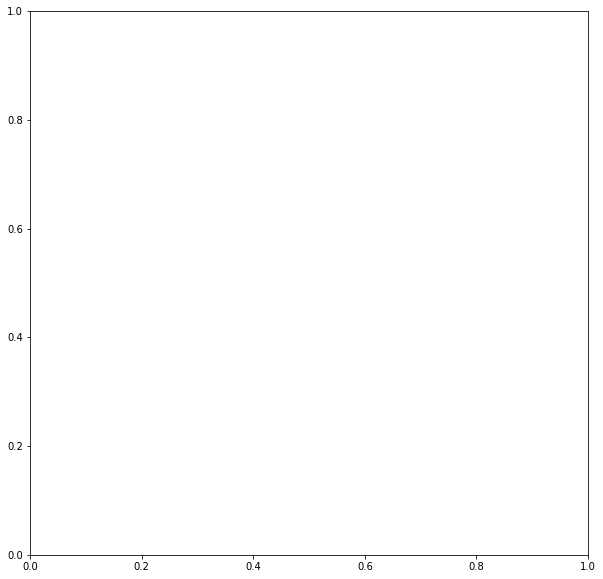

In [38]:
colors = np.zeros(data_train.num_nodes)

_ = draw_kkl(data_train, None, colors, cmap='gist_rainbow', edge_color='gray')

In [ ]:
# finally, build the graph (if other attributes e.g. edge_features, you can also pass it there)
data = Data(x=x, edge_index=edge_index, y=y)

return data

In [ ]:
# finally, build the graph (if other attributes e.g. edge_features, you can also pass it there)
data = Data(x=x, edge_index=edge_index, y=y)

return data

In [18]:
import numpy as np
from scipy.linalg import sqrtm 
from scipy.special import softmax
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from IPython.display import HTML

In [19]:
def draw_kkl(nx_G, label_map, node_color, pos=None, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10))
    if pos is None:
        pos = nx.spring_layout(nx_G, k=5/np.sqrt(nx_G.number_of_nodes()))

    nx.draw(
        nx_G, pos, with_labels=label_map is not None, 
        labels=label_map, 
        node_color=node_color, 
        ax=ax, **kwargs)

In [20]:
data_train.num_nodes, data_train.num_edges

(14450, 11577388)

In [21]:
communities = greedy_modularity_communities(data_train)

AttributeError: 'GlobalStorage' object has no attribute 'number_of_nodes'

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [ ]:
data = data_train  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
#print(f'Number of training nodes: {data.train_mask.sum()}')
#print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
#print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')

By printing edge_index, we can understand how PyG represents graph connectivity internally. We can see that for each edge, edge_index holds a tuple of two node indices, where the first value describes the node index of the source node and the second value describes the node index of the destination node of an edge.

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.transpose())

We can further visualize the graph by converting it to the networkx library format, which implements, in addition to graph manipulation functionalities, powerful tools for visualization:

In [ ]:
tf.convert_to_tensor(data.y)

In [ ]:
array_test = np.ones(3)
torch.Tensor(array_test)

In [ ]:
Data

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(tf.convert_to_tensor(data), to_undirected=True)
visualize_graph(G, color=tf.convert_to_tensor(data.y))

Here, there was the code of yesterday:

In [ ]:
import torch
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data_train.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2) # number of classes on the data

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

**Embedding the Census Network**

Let's take a look at the node embeddings produced by our GNN.
Here, we pass in the initial node features `x` and the graph connectivity information `edge_index` to the model, and visualize its 2-dimensional embedding.

In [ ]:
model = GCN()

_, h = model(data_train.x, data_train.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data_train.y)

In [ ]:
pip install IPython

In [ ]:
data_train

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data_train.x, data_train.edge_index)  # Perform a single forward pass.
    loss = criterion(out, data_train.y)  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test():
    model.eval()
    out = model(data_valid.x, data_valid.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred == data_test.y  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data_test.sum())  # Derive ratio of correct predictions.
    return test_acc

for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

In [ ]:
augmented_train_valid_set = augment_train_valid_set_with_results("uncorrected", X_train_valid, Y_train_valid, Y_pred_train_valid, model_task)

We now see that this process with basic data preparation, modelling and integration of the results in a DataFrame (as storage of the model) is very fast (in seconds):

In [ ]:
t1 = time.time()

print(f"Basic modelling took {round(t1 - t0)} seconds")

The further steps are for fairness assessment and correction of the model, functionality which is available with the package FairDream of DreamQuark (private for the moment)...

## Detection alert (on train&valid data to examine if the model learned discriminant behavior)

## Discrimination correction with a new fair model

### Generating fairer models with grid search or weights distorsion

### Evaluating the best fair model